In [4]:
'------------------------------------------------- Initial Setup -------------------------------------------------'

%matplotlib inline
import itertools
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from pprint import pprint
from itertools import cycle
import matplotlib.pyplot as plt
from collections import OrderedDict
from xgboost import XGBClassifier
from TrainTestSplit import trainTestSplit
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

# Set the random seed to a specific value (e.g., 42)
np.random.seed(42)

np.set_printoptions(precision = 2)

In [5]:
## Loading in the data of Set A.
XTrain, XTest, YTrain, YTest = trainTestSplit("A")

In [6]:
## Setting the classifier to be Vanilla XGBoostClassifier.
Classifier = XGBClassifier()

## Defining a list to store the Cross-Validation Scores.
crossValidationScores = []

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable
YTrain_encoded = label_encoder.fit_transform(YTrain['FTR'])
YTest_encoded = label_encoder.fit_transform(YTest['FTR'])

# Convert NumPy array to pandas DataFrame
YTrain_encoded_df = pd.DataFrame({'E_FTR': YTrain_encoded})
YTest_encoded_df = pd.DataFrame({'E_FTR': YTest_encoded})

## Computing the 10-fold cross-validation score.
cvScore = cross_val_score(Classifier, XTrain, YTrain_encoded_df['E_FTR'], cv = 10)
crossValidationScores.append(np.mean(cvScore))
print ("Cross Validation Score : ", np.mean(crossValidationScores))

## Computing the Training and Testing Accuracies.
Classifier.fit(XTrain,YTrain_encoded_df)
print ("Training Accuracy : ", Classifier.score(XTrain, YTrain_encoded_df))
print ("Testing Accuracy : ", Classifier.score(XTest, YTest_encoded_df))

Cross Validation Score :  0.4784948847448848
Training Accuracy :  0.9982910851609228
Testing Accuracy :  0.4859375


In [7]:
## Defining the hyperparameter space for searching the optimum set of hyperparameter values .
parameters = { 'max_depth' : [3, 5],
               'gamma' : [0.01, 0.02],
               'learning_rate' : [0.01, 0.025],
               'reg_lambda' : [0.01, 0.025]
              }

'''
## Defining the hyperparameter space for searching the optimum set of hyperparameter values .
parameters = { 'max_depth' : [3, 5, 6, 9, 12, 15, 17, 25],
               'gamma' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5],
               'learning_rate' : [0.01, 0.025, 0.05, 0.1],
               'reg_lambda' : [0.01, 0.025, 0.075, 0.1, 0.2, 0.6, 1.0, 0.05]
              }
'''

"\n## Defining the hyperparameter space for searching the optimum set of hyperparameter values .\nparameters = { 'max_depth' : [3, 5, 6, 9, 12, 15, 17, 25],\n               'gamma' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5],\n               'learning_rate' : [0.01, 0.025, 0.05, 0.1],\n               'reg_lambda' : [0.01, 0.025, 0.075, 0.1, 0.2, 0.6, 1.0, 0.05]\n              }\n"

In [8]:
# Loading the already tuned model with the above set of hyperparameters.
#Clf = joblib.load('../GridSearchObjects/XGBSetA.pkl')

In [9]:
# # Uncomment this block if you want to run the grid search yourself.
# # Note : This is going to be computationally very expensive on your CPU !

Clf1 = GridSearchCV(Classifier, parameters, n_jobs = 5, verbose = 4, scoring = 'accuracy')

# ## Fitting the Model to the Training Data.
Clf1.fit(XTrain, YTrain_encoded_df.values.ravel())

# # Saving the grid search object.
joblib.dump(Clf1, '../GridSearchObjects/XGBSetA.pkl')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


['../GridSearchObjects/XGBSetAll.pkl']

In [10]:
## Printing the statistics after hyper-parameter tuning.
print (Clf1.best_score_)
print (Clf1.best_estimator_)

0.5328936223673066
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)


In [11]:
## Setting the classifier to be the hyperparameter tuned Random Forest Classifier.
Classifier = Clf1.best_estimator_

## Defining a list to store the Cross-Validation Scores.
crossValidationScores = []

## Computing the 10-fold cross-validation score.
cvScore = cross_val_score(Classifier, XTrain, YTrain_encoded_df['E_FTR'], cv = 10)
crossValidationScores.append(np.mean(cvScore))
print ("Cross Validation Score : ", np.mean(crossValidationScores))

## Computing the Training and Testing Accuracies.
Classifier.fit(XTrain,YTrain_encoded_df)
print ("Training Accuracy : ", Classifier.score(XTrain, YTrain_encoded_df))
print ("Testing Accuracy : ", Classifier.score(XTest, YTest_encoded_df))

Cross Validation Score :  0.5314693408443409
Training Accuracy :  0.559099971518086
Testing Accuracy :  0.55


In [12]:
## Obtaining our predictions made by the best Gaussian Naive Bayes Classifier .
YPred = Classifier.predict(XTest)

## Defining the target classes .
classLabels = ['0','1','2']

## Obtaining the confusion matrix for our predictions .
confusionMatrix = confusion_matrix(y_true= YTest_encoded_df['E_FTR'], y_pred=YPred, labels=classLabels)

In [13]:
## Obtaining a more readable format of our Confusion Matrix in terms of a Classification Report . 

classificationReport = classification_report(y_true=YTest_encoded_df, y_pred=YPred, labels=classLabels)
print (classificationReport)

              precision    recall  f1-score   support

           0       0.57      0.47      0.52       174
           1       0.25      0.01      0.01       158
           2       0.55      0.87      0.67       308

   micro avg       0.55      0.55      0.55       640
   macro avg       0.46      0.45      0.40       640
weighted avg       0.48      0.55      0.47       640



<Axes: xlabel='learningRate', ylabel='gamma'>

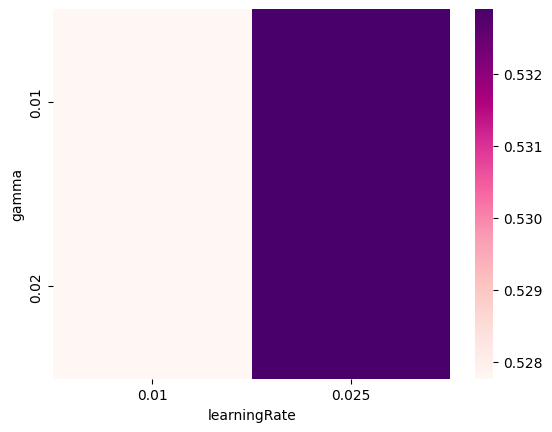

In [14]:
gridScores = Clf1.cv_results_

gridScoresList = []

for i in range(0, len(gridScores['params'])):

    Score = (gridScores['mean_test_score'][i],)

    learningRate = (gridScores['params'][i]['learning_rate'],)
    gamma = (gridScores['params'][i]['gamma'],)

    Tuple = Score + learningRate + gamma
    gridScoresList.append(Tuple)
    
df = pd.DataFrame(gridScoresList, columns = ['Validation Score', 'learningRate', 'gamma'])

df = df.drop_duplicates(subset = ['learningRate', 'gamma'])
## df = df[np.isfinite(df['maxDepth'])]

gridMap = df.pivot(index = "gamma", columns="learningRate", values ="Validation Score")

sns.heatmap(gridMap, cmap = "RdPu")

<Axes: xlabel='maxDepth', ylabel='regLambda'>

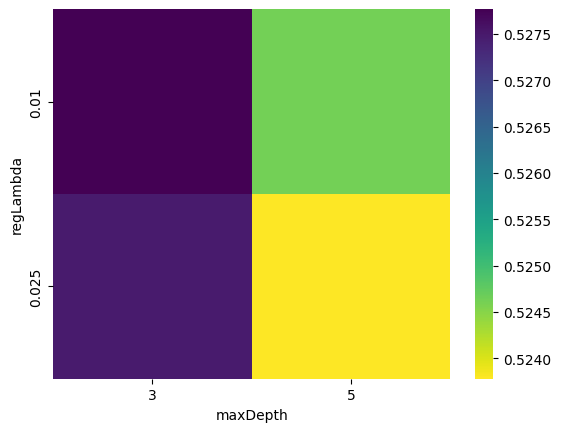

In [15]:
gridScores = Clf1.cv_results_

gridScoresList = []

for i in range(0, len(gridScores['params'])):

    Score = (gridScores['mean_test_score'][i],)
    regLambda = (gridScores['params'][i]['reg_lambda'],)
    maxDepth = (gridScores['params'][i]['max_depth'],)

    Tuple = Score + regLambda + maxDepth
    gridScoresList.append(Tuple)
    
df = pd.DataFrame(gridScoresList, columns = ['Validation Score', 'regLambda', 'maxDepth'])
df = df.drop_duplicates(subset = ['regLambda', 'maxDepth'])

gridMap = df.pivot(index = "regLambda", columns= "maxDepth", values="Validation Score")
sns.heatmap(gridMap, cmap = "viridis_r")